# Определение уровня сложности англоязычных фильмов

Задача - разработать ML решение для автоматического определения уровня сложности англоязычных фильмов.

## Подготовка среды

In [ ]:
import glob
import pathlib
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pysrt
import spacy
from catboost import CatBoostClassifier
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imba
from itertools import islice
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from pandarallel import pandarallel
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from tqdm.auto import tqdm


Инициализация библиотек для параллельного выполнения.

In [2]:
tqdm.pandas()
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Скачивание языковых моделей и данных.

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/doburla1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/doburla1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/doburla1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Подготовка данных

In [5]:
df = pd.read_excel('../data/movies_labels.xlsx', index_col='id')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   241 non-null    object
 1   Level   241 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


In [7]:
df.head()

Movie   Level
id                                          
0          10_Cloverfield_lane(2016)      B1
1   10_things_I_hate_about_you(1999)      B1
2               A_knights_tale(2001)      B2
3               A_star_is_born(2018)      B2
4                      Aladdin(1992)  A2/A2+

В датасете для каждого фильма указан его уровень. Субтитры хранятся отдельно, их необходимо добавить в датасет.

Проверим дубликаты.

In [8]:
df[df.duplicated()]

Movie Level
id                        
44  Inside_out(2015)    B1
68      Powder(1995)    B1

Два фильма дублируются, удалим.

In [9]:
df = df.drop_duplicates()
df[df.duplicated()]

Empty DataFrame
Columns: [Movie, Level]
Index: []

Создадим датасет с субтитрами, субтитры распределены по нескокльким папкам, некоторые субтитры расссортированы по уровням, будем использовать эту информацию.

In [10]:
def subs_text(path):
    try:
        srt = pysrt.open(path)
    except UnicodeDecodeError:
        srt = pysrt.open(path, encoding='iso-8859-1')
    text = srt.text
    return text

def process_path(path):
    filename = pathlib.Path(path).stem
    level = pathlib.Path(path).parent.name
    if level not in ('A1', 'A2', 'B1', 'B2', 'C1'):
        level = None
    text = subs_text(path)
    return filename, text, level

res = Parallel(n_jobs=-1)(delayed(process_path)(path) for path in tqdm(glob.glob('../data/Subtitles_all/**/*.srt', recursive=True)))

movies = []
subs = []
levels = []
for item in res:
    movies.append(item[0])
    subs.append(item[1])
    levels.append(item[2])

subs_df = pd.DataFrame(data={'Movie': movies, 'subs': subs, 'Level': levels})

  0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   300 non-null    object
 1   subs    300 non-null    object
 2   Level   177 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [12]:
subs_df.head()

Movie   
0            Crown, The S01E01 - Wolferton Splash.en  \
1                            Suits.Episode 1- Denial   
2  Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...   
3                      Suits.S02E08.HDTV.x264-EVOLVE   
4  Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE   

                                                subs Level  
0  In seeking his British\nnationalization, His R...    B2  
1  You're the most amazing woman\nI have ever met...    B2  
2  (HARVEY READING)\nI've been after Sutter\nfor ...    B2  
3  [Car horn blares]\nYou're late.\nNope. 30 seco...    B2  
4  Are you sure I can't convince you to stay?\nNo...    B2

Соединим два датасета в один по имени фильма.

In [13]:
df = df.merge(subs_df, how='outer', on='Movie')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Movie    302 non-null    object
 1   Level_x  239 non-null    object
 2   subs     302 non-null    object
 3   Level_y  177 non-null    object
dtypes: object(4)
memory usage: 9.6+ KB


Датасет расширился за счет рассортированных субтитров, соберем значение уровня из колонок из обоих датасетов.

In [15]:
df['Level'] = df['Level_x'].fillna(df['Level_y'])
df = df.drop(columns=['Level_x', 'Level_y'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   302 non-null    object
 1   subs    302 non-null    object
 2   Level   293 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


Часть фильмов осталаь без уровня, удалим их, они не дают никакой информации.

In [17]:
df = df.dropna()

In [18]:
df.head()

Movie   
0         10_Cloverfield_lane(2016)  \
1  10_things_I_hate_about_you(1999)   
2              A_knights_tale(2001)   
3              A_star_is_born(2018)   
4                     Aladdin(1992)   

                                                subs   Level  
0  <font color="#ffff80"><b>Fixed & Synced by boz...      B1  
1  Hey!\nI'll be right with you.\nSo, Cameron. He...      B1  
2  Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...      B2  
3  - <i><font color="#ffffff"> Synced and correct...      B2  
4  <i>Oh, I come from a land\nFrom a faraway plac...  A2/A2+

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 292
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   293 non-null    object
 1   subs    293 non-null    object
 2   Level   293 non-null    object
dtypes: object(3)
memory usage: 9.2+ KB


Итого имеем 293 фильма.

Посмотрим на распределение фильмов по уровням.

In [20]:
df['Level'].value_counts()

Level
B2            146
B1             56
C1             45
A2/A2+         26
B1, B2          8
A2              7
A2/A2+, B1      5
Name: count, dtype: int64

В данных наблюдается дисбаланс, мало фильмов уровня A2, также представлены промежуточные классы. Фильмов промежуточных классов немного, врядли модель научится их определять. Лучшим вариантов представляется преобразовать промежуточные уровни в основные, заменив промежуточные уровня на следующий основной.

In [21]:
df['Level'] = df['Level'].replace({
    'A2/A2+':'B1',
    'A2/A2+, B1': 'B1',
    'B1, B2': 'B2'
})

In [22]:
df['Level'].value_counts()

Level
B2    154
B1     87
C1     45
A2      7
Name: count, dtype: int64

В четырех классах разобраться будет легче, но фильмов уровня A2 все равно очень мало.

## Преобразование данных.

### Очистка

Создадим трансформер, очищающий субтитры от тегов, символов, комментариев, пунктуации.

In [23]:
class CleanSubs(BaseEstimator, TransformerMixin):
    HTML = r'<.*?>'
    TAG = r'{.*?}'
    COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
    LETTERS = r'[^a-zA-Z\']'
    SPACES = r'([ ])\1+'
    DOTS = r'[\.]+'

    @classmethod
    def clean_subs(cls, subs):
        subs = re.sub(cls.HTML, ' ', subs) #html тэги меняем на пробел
        subs = re.sub(cls.TAG, ' ', subs) #тэги меняем на пробел
        subs = re.sub(cls.COMMENTS, ' ', subs) #комменты меняем на пробел
        subs = re.sub(cls.LETTERS, ' ', subs) #все что не буквы меняем на пробел
        subs = re.sub(cls.SPACES, r'\1', subs) #повторяющиеся пробелы меняем на один пробел
        subs = re.sub(cls.DOTS, r'.', subs) #многоточие меняем на точку
        subs = subs.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы
        # subs = ".".join(subs.lower().split('.')[1:-1]) #удаляем первый и последний субтитр (обычно это реклама)
        return subs.lower()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['subs'] = X['subs'].parallel_apply(self.clean_subs)
        return X

In [24]:
CleanSubs().fit_transform(df.head())

Movie   
0         10_Cloverfield_lane(2016)  \
1  10_things_I_hate_about_you(1999)   
2              A_knights_tale(2001)   
3              A_star_is_born(2018)   
4                     Aladdin(1992)   

                                                subs Level  
0   fixed synced by bozxphd enjoy the flick ben o...    B1  
1  hey i'll be right with you so cameron here you...    B1  
2  resync xenzai retail should we help him he's d...    B2  
3   synced and corrected by mrcjnthn get to it bl...    B2  
4   oh i come from a land from a faraway place wh...    B1

Субтитры очищаются.

### Лемматизация

Создадим трансформер, приводящий слова в их начальную форму, воспользуемся обученной моделью spacy.

In [25]:
class LemmatizeSub(BaseEstimator, TransformerMixin):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'tok2vec'])

    @classmethod
    def lemmatize(cls, subs):
        doc = cls.nlp(subs)
        tokens = nltk.word_tokenize(subs)
        return ' '.join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['subs'] = X['subs'].parallel_apply(self.lemmatize)
        if y is None:
            return X
        else:
            return X, y

In [26]:
make_pipeline(CleanSubs(), LemmatizeSub()).fit_transform(df.head())

Movie   
0         10_Cloverfield_lane(2016)  \
1  10_things_I_hate_about_you(1999)   
2              A_knights_tale(2001)   
3              A_star_is_born(2018)   
4                     Aladdin(1992)   

                                                subs Level  
0  fixed synced by bozxphd enjoy the flick ben on...    B1  
1  hey i 'll be right with you so cameron here yo...    B1  
2  resync xenzai retail should we help him he 's ...    B2  
3  synced and corrected by mrcjnthn get to it bla...    B2  
4  oh i come from a land from a faraway place whe...    B1

In [27]:
import difflib
from IPython.core.display import HTML
before = make_pipeline(CleanSubs()).fit_transform(df.head(1))['subs'][0]
after = make_pipeline(CleanSubs(), LemmatizeSub()).fit_transform(df.head(1))['subs'][0]

In [28]:
HTML(difflib.HtmlDiff().make_file(before, after, context=True))

### Подсчет слов по уровням.

Сгенерируем новые признаки. Подсчитаем соотношение слов, относящихся к определенному уровню, ко все словам в субтитрах

In [29]:
class WordsLevel(BaseEstimator, TransformerMixin):

    @staticmethod
    def load_vocabulary(vocabulary_path):
        with open(vocabulary_path) as f:
            full = f.readlines()

        full = [line.split()[0].lower() for line in full]

        a1_index = full.index('a1')
        a2_index = full.index('a2')
        b1_index = full.index('b1')
        b2_index = full.index('b2')
        c1_index = full.index('c1')

        a1 = set(full[a1_index + 1: a2_index])
        a2 = set(full[a2_index + 1: b1_index])
        b1 = set(full[b1_index + 1: b2_index])
        b2 = set(full[b2_index + 1: c1_index])
        c1 = set(full[c1_index + 1:])

        return a1, a2, b1, b2, c1

    def __init__(self):
        vocabulary_path='../data/vocabulary/american/full.txt'
        self.a1, self.a2, self.b1, self.b2, self.c1 = self.load_vocabulary(vocabulary_path)
        super().__init__()

    def count_word_level(self, text):
        words = text.split()
        a1_count = 0
        a2_count = 0
        b1_count = 0
        b2_count = 0
        c1_count = 0
        other_count = 0

        total = len(words)

        for word in words:
            if word in self.a1:
                a1_count += 1
            elif word in self.a2:
                a2_count += 1
            elif word in self.b1:
                b1_count += 1
            elif word in self.b2:
                b2_count += 1
            elif word in self.c1:
                c1_count += 1
            else:
                other_count += 1
        return a1_count, a2_count, b1_count, b2_count, c1_count, other_count, total

    @staticmethod
    def _expand_array(row):
        return pd.Series(row)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        stats = X['subs'].parallel_apply(self.count_word_level)
        stats = stats.parallel_apply(self._expand_array)
        stats.columns = ['a1_count', 'a2_count', 'b1_count', 'b2_count', 'c1_count', 'other_count', 'total']
        X = X.merge(stats, left_index=True, right_index=True)
        X['a1_coef'] = X['a1_count'] / X['total']
        X['a2_coef'] = X['a2_count'] / X['total']
        X['b1_coef'] = X['b1_count'] / X['total']
        X['b2_coef'] = X['b2_count'] / X['total']
        X['c1_coef'] = X['c1_count'] / X['total']
        X['other_coef'] = X['other_count'] / X['total']
        X = X.drop(columns=['a1_count', 'a2_count', 'b1_count', 'b2_count', 'c1_count', 'other_count', 'total'])
        if y is None:
            return X
        else:
            return X, y

In [30]:
make_pipeline(CleanSubs(), LemmatizeSub(), WordsLevel()).fit_transform(df.head())

Movie   
0         10_Cloverfield_lane(2016)  \
1  10_things_I_hate_about_you(1999)   
2              A_knights_tale(2001)   
3              A_star_is_born(2018)   
4                     Aladdin(1992)   

                                                subs Level   a1_coef   
0  fixed synced by bozxphd enjoy the flick ben on...    B1  0.672563  \
1  hey i 'll be right with you so cameron here yo...    B1  0.680858   
2  resync xenzai retail should we help him he 's ...    B2  0.638998   
3  synced and corrected by mrcjnthn get to it bla...    B2  0.699139   
4  oh i come from a land from a faraway place whe...    B1  0.630458   

    a2_coef   b1_coef   b2_coef   c1_coef  other_coef  
0  0.046530  0.018843  0.013267  0.004614    0.244184  
1  0.037041  0.016036  0.016149  0.007453    0.242462  
2  0.052452  0.019932  0.025308  0.010753    0.252557  
3  0.035793  0.010816  0.012809  0.004554    0.236889  
4  0.053431  0.028951  0.022125  0.008003    0.257032

### Векторизация

Векторизуем субтитры, понизим размерность, чтобы не запутывать модель малоинформативными данными.

In [31]:
class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=1500, min_df=7, max_df=0.7, PCA=None):
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.PCA = PCA

    def fit(self, X, y=None):
        tfidfvectorizer = TfidfVectorizer(max_features=self.max_features, min_df=self.min_df, max_df=self.max_df, stop_words=stopwords.words('english'))
        tfidfvectorizer.fit(X['subs'])
        self.tfidfvectorizer = tfidfvectorizer
        if self.PCA:
            tfidf_wm = self.tfidfvectorizer.transform(X['subs'])
            tfidf_tokens = self.tfidfvectorizer.get_feature_names_out()
            tfidf_tokens = ['tfidf_' + token for token in tfidf_tokens]
            df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), columns = tfidf_tokens, index=X.index)
            svd = TruncatedSVD(n_components=self.PCA, random_state=12345)
            svd.set_output(transform='pandas')
            svd.fit(df_tfidfvect)
            self.svd = svd
        return self

    def transform(self, X, y=None):
        tfidf_wm = self.tfidfvectorizer.transform(X['subs'])
        tfidf_tokens = self.tfidfvectorizer.get_feature_names_out()
        tfidf_tokens = ['tfidf_' + token for token in tfidf_tokens]
        df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), columns = tfidf_tokens, index=X.index)
        if self.PCA:
            df_tfidfvect = self.svd.transform(df_tfidfvect)
        X = X.merge(df_tfidfvect, left_index=True, right_index=True)
        if y is None:
            return X
        else:
            return X, y

In [32]:
make_pipeline(CleanSubs(), LemmatizeSub(), WordsLevel(), Vectorizer(min_df=2, max_features=10, PCA=5)).fit_transform(df.head())

Movie   
0         10_Cloverfield_lane(2016)  \
1  10_things_I_hate_about_you(1999)   
2              A_knights_tale(2001)   
3              A_star_is_born(2018)   
4                     Aladdin(1992)   

                                                subs Level   a1_coef   
0  fixed synced by bozxphd enjoy the flick ben on...    B1  0.672563  \
1  hey i 'll be right with you so cameron here yo...    B1  0.680858   
2  resync xenzai retail should we help him he 's ...    B2  0.638998   
3  synced and corrected by mrcjnthn get to it bla...    B2  0.699139   
4  oh i come from a land from a faraway place whe...    B1  0.630458   

    a2_coef   b1_coef   b2_coef   c1_coef  other_coef  truncatedsvd0   
0  0.046530  0.018843  0.013267  0.004614    0.244184       0.551896  \
1  0.037041  0.016036  0.016149  0.007453    0.242462       0.799229   
2  0.052452  0.019932  0.025308  0.010753    0.252557       0.081860   
3  0.035793  0.010816  0.012809  0.004554    0.236889       0.886929   
4  0.053431  0.028951  0.022125  0.008003    0.257032       0.285767   

   truncatedsvd1  truncatedsvd2  truncatedsvd3  truncatedsvd4  
0       0.053160       0.592971       0.564539      -0.149216  
1      -0.166045      -0.389948      -0.223863      -0.362613  
2       0.757794      -0.513273       0.393794       0.022912  
3      -0.171377      -0.101334      -0.010904       0.416653  
4       0.676547       0.406945      -0.543149       0.002609

### Удаление текстового признака

Текст субтитров векторизован, отбросим признак с текстом.

In [33]:
class DropSubs(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X = X.drop(columns=['subs'])
        if y is None:
            return X
        else:
            return X, y

In [34]:
make_pipeline(CleanSubs(), LemmatizeSub(), WordsLevel(), Vectorizer(min_df=2, max_features=10, PCA=5), DropSubs()).fit_transform(df.head())

Movie Level   a1_coef   a2_coef   b1_coef   
0         10_Cloverfield_lane(2016)    B1  0.672563  0.046530  0.018843  \
1  10_things_I_hate_about_you(1999)    B1  0.680858  0.037041  0.016036   
2              A_knights_tale(2001)    B2  0.638998  0.052452  0.019932   
3              A_star_is_born(2018)    B2  0.699139  0.035793  0.010816   
4                     Aladdin(1992)    B1  0.630458  0.053431  0.028951   

    b2_coef   c1_coef  other_coef  truncatedsvd0  truncatedsvd1   
0  0.013267  0.004614    0.244184       0.551896       0.053160  \
1  0.016149  0.007453    0.242462       0.799229      -0.166045   
2  0.025308  0.010753    0.252557       0.081860       0.757794   
3  0.012809  0.004554    0.236889       0.886929      -0.171377   
4  0.022125  0.008003    0.257032       0.285767       0.676547   

   truncatedsvd2  truncatedsvd3  truncatedsvd4  
0       0.592971       0.564539      -0.149216  
1      -0.389948      -0.223863      -0.362613  
2      -0.513273       0.393794       0.022912  
3      -0.101334      -0.010904       0.416653  
4       0.406945      -0.543149       0.002609

### Разбивка субтитров

В датасете представлено мало фильмов, попробуем увеличить набор данных, разбив текст субтитров на несколько частей и будем считать что все эти части имеют тот же самый уровень сложности.

In [35]:
def batched(iterable, chunk_size):
            iterator = iter(iterable)
            while chunk := tuple(islice(iterator, chunk_size)):
                yield chunk

def split_subs(X, y, n_splits=10):
    X_split  = []
    y_split = []
    for index, row in X.iterrows():
        subs = row['subs'].split()
        split_subs = np.array_split(subs, n_splits)
        for split in split_subs:
            X_split.append(' '.join(split))
            y_split.append(y.loc[index])

    X_split = pd.DataFrame({'subs': X_split})
    y_split = pd.Series(y_split)

    return shuffle(X_split, y_split, random_state=12345)

In [36]:
split_subs_sampler = FunctionSampler(func=split_subs, kw_args={'n_splits': 3}, accept_sparse=False, validate=False)
split_subs_sampler.fit_resample(df[['subs']].head(3), df['Level'].head(3))

[                                                subs
 3  Hey! I'll be right with you. So, Cameron. Here...
 0  <font color="#ffff80"><b>Fixed & Synced by boz...
 8  you in the lists! Lichtenstein! Lichtenstein! ...
 6  Resync: Xenzai[NEF] RETAIL Should we help him?...
 4  a seizure. Is this about Sarah Lawrence? Are y...
 1  It's delicious. That's the best sauce I've eve...
 7  For you are all equally blessed. For I have th...
 5  thousand suns." That's a direct quote. Thanks,...
 2  But what if up there it's like... What? Lumber...,
 3    B1
 0    B1
 8    B2
 6    B2
 4    B1
 1    B1
 7    B2
 5    B1
 2    B1
 dtype: object]

### Подготовка выборок

In [37]:
features, target = df[['subs']], df['Level']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=12345, stratify=target
)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)
print(target_train.value_counts())
print(target_test.value_counts())

(219, 1) (74, 1) (219,) (74,)
Level
B2    115
B1     65
C1     34
A2      5
Name: count, dtype: int64
Level
B2    39
B1    22
C1    11
A2     2
Name: count, dtype: int64


## Обучение моделей

### Базовая модель

Посмотрим на метрику, если предсказывать все время самый большой класс.

In [39]:
dummy_model = DummyClassifier()
dummy_model.fit(features_train, target_train)
dummy_pred = dummy_model.predict((features_test))
print(f'Balanced accuracy: {balanced_accuracy_score(target_test, dummy_pred):.2f}')

Balanced accuracy: 0.25


### Комбинации трансформеров

Будем проводить кросс-валидацию на различных комбинациях трансформеров. Так как в данных есть дисбаланс, то для разбиения на фолды будем использовать стратификацию, а в качестве метрики возмем balanced accuracy, также попробуем произвести апсемплинг.

In [40]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=12345)

In [41]:
subs_sampler_x2 = FunctionSampler(func=split_subs, kw_args={'n_splits': 2}, accept_sparse=False, validate=False)

In [42]:
smote = SMOTE(k_neighbors=3, random_state=12345)

#### CatBoost со встроенной обработкой текста

Посмотрим на метрику катбуста на необработанных до векторизациия, с использованием встроенной обработки текста.

In [45]:
cb_text_model = CatBoostClassifier(verbose=0, iterations=100, text_features=['subs'], auto_class_weights='Balanced')

In [44]:
pipeline = make_pipeline(cb_text_model)
cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.398) total time=  27.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.2s remaining:    0.0s


[CV] END ................................ score: (test=0.360) total time=  20.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.6s remaining:    0.0s


[CV] END ................................ score: (test=0.327) total time=  29.6s
[CV] END ................................ score: (test=0.449) total time=  21.6s
Balanced accuracy: 0.38, std: 0.05


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min finished


In [44]:
pipeline = make_pipeline(
    CleanSubs(),
    cb_text_model
)
cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.441) total time=  28.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s


[CV] END ................................ score: (test=0.483) total time=  28.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.1s remaining:    0.0s


[CV] END ................................ score: (test=0.422) total time=  27.5s
[CV] END ................................ score: (test=0.516) total time=  27.7s
Balanced accuracy: 0.47, std: 0.04


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min finished


In [45]:
pipeline = make_pipeline(
    CleanSubs(),
    LemmatizeSub(),
    cb_text_model
)
cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.428) total time=  46.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.7s remaining:    0.0s


[CV] END ................................ score: (test=0.466) total time=  46.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.436) total time=  46.8s
[CV] END ................................ score: (test=0.417) total time=  47.4s
Balanced accuracy: 0.44, std: 0.02


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.1min finished


In [46]:
pipeline = make_pipeline(
    CleanSubs(),
    LemmatizeSub(),
    WordsLevel(),
    cb_text_model
)
cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.450) total time=  47.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.4s remaining:    0.0s


[CV] END ................................ score: (test=0.415) total time=  47.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.398) total time= 1.0min
[CV] END ................................ score: (test=0.375) total time=  39.8s
Balanced accuracy: 0.41, std: 0.03


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.3min finished


In [47]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    WordsLevel(),
    cb_text_model
)
cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.545) total time=  43.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.0s remaining:    0.0s


[CV] END ................................ score: (test=0.584) total time=  39.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] END ................................ score: (test=0.522) total time=  38.4s
[CV] END ................................ score: (test=0.506) total time=  38.3s
Balanced accuracy: 0.54, std: 0.03


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min finished


С применением очистки, лемматизации, разбиение и подсчета слов встроенная текстовая обработка катбуста смогла достичь метрики 0.54, со стандартным отклонение 0.03

#### CatBoost c преобразованнием текста в числа

In [48]:
model = CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')

In [49]:
pipeline = make_pipeline(
    CleanSubs(),
    WordsLevel(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.528) total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ................................ score: (test=0.266) total time=   1.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END ................................ score: (test=0.286) total time=   1.3s
[CV] END ................................ score: (test=0.533) total time=   1.3s
Balanced accuracy: 0.40, std: 0.13


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.2s finished


In [50]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    subs_sampler_x2,
    WordsLevel(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.334) total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ................................ score: (test=0.306) total time=   2.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END ................................ score: (test=0.390) total time=   2.0s
[CV] END ................................ score: (test=0.471) total time=   2.1s
Balanced accuracy: 0.38, std: 0.06


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s finished


In [51]:
pipeline = make_pipeline(
    CleanSubs(),
    LemmatizeSub(),
    WordsLevel(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.223) total time=  15.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV] END ................................ score: (test=0.268) total time=  17.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.4s remaining:    0.0s


[CV] END ................................ score: (test=0.334) total time=  17.0s
[CV] END ................................ score: (test=0.498) total time=  36.7s
Balanced accuracy: 0.33, std: 0.10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min finished


In [52]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    WordsLevel(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=2)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  25.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s remaining:    0.0s


[CV] END .................................................... total time=  20.6s
[CV] END .................................................... total time=  18.5s
[CV] END .................................................... total time=  18.8s
Balanced accuracy: 0.36, std: 0.08


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min finished


In [53]:
pipeline = make_pipeline(
    CleanSubs(),
    LemmatizeSub(),
    Vectorizer(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.462) total time=  24.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s


[CV] END ................................ score: (test=0.337) total time=  25.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.6s remaining:    0.0s


[CV] END ................................ score: (test=0.369) total time=  25.3s
[CV] END ................................ score: (test=0.359) total time=  25.2s
Balanced accuracy: 0.38, std: 0.05


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min finished


In [54]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    Vectorizer(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.521) total time=  29.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.4s remaining:    0.0s


[CV] END ................................ score: (test=0.450) total time=  28.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.1s remaining:    0.0s


[CV] END ................................ score: (test=0.415) total time=  28.7s
[CV] END ................................ score: (test=0.361) total time=  29.7s
Balanced accuracy: 0.44, std: 0.06


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min finished


In [55]:
pipeline = make_pipeline(
    CleanSubs(),
    LemmatizeSub(),
    WordsLevel(),
    Vectorizer(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.471) total time=  25.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] END ................................ score: (test=0.346) total time=  26.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.9s remaining:    0.0s


[CV] END ................................ score: (test=0.461) total time=  26.0s
[CV] END ................................ score: (test=0.393) total time=  25.5s
Balanced accuracy: 0.42, std: 0.05


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min finished


In [56]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    WordsLevel(),
    Vectorizer(),
    DropSubs(),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.461) total time=  28.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s


[CV] END ................................ score: (test=0.403) total time=  29.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.0s remaining:    0.0s


[CV] END ................................ score: (test=0.421) total time=  29.2s
[CV] END ................................ score: (test=0.624) total time=  29.0s
Balanced accuracy: 0.48, std: 0.09


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min finished


Подход с векторизацией и разбиением субтитров дает наилучшую метрику, продолжим в этом же направлении, попробуем подобрать гипперпараметры. Без их подбора встроенная в катбуст обработка текста показала лучшую метрику. Так как данных в некоторых категориях мало, попробуем сгенерировать синтетические данные

In [46]:
model = CatBoostClassifier(iterations=100, verbose=0)

In [47]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    Vectorizer(),
    DropSubs(),
    SMOTE(k_neighbors=3, random_state=12345),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.450) total time=  48.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.3s remaining:    0.0s


[CV] END ................................ score: (test=0.457) total time=  45.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.554) total time=  45.5s
[CV] END ................................ score: (test=0.708) total time=  35.5s
Balanced accuracy: 0.54, std: 0.10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.9min finished


In [48]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    WordsLevel(),
    Vectorizer(),
    DropSubs(),
    SMOTE(k_neighbors=3, random_state=12345),
    model
)

cv_score = cross_val_score(pipeline, features_train, target_train, scoring='balanced_accuracy', cv=cv, verbose=3)
print(f'Balanced accuracy: {cv_score.mean():.2f}, std: {cv_score.std():.2f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.803) total time=  45.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.0s remaining:    0.0s


[CV] END ................................ score: (test=0.412) total time=  36.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] END ................................ score: (test=0.567) total time=  36.2s
[CV] END ................................ score: (test=0.402) total time=  36.6s
Balanced accuracy: 0.55, std: 0.16


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min finished


Апсемплинг позовляет улушить метрику, теперь подберем гипперпараметры.

#### Подбор гиперпараметров

Найдем оптимальные гиперпараметры для векторизации и модели классификации. Так как комбинаций параметров много, воспользуемся RandomizedSearchCV

##### Встроенная обработка текстов

In [45]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    WordsLevel(),
    cb_text_model
)

fit_params = {
    'catboostclassifier__depth': sp_randInt(3, 10),
    'catboostclassifier__iterations': sp_randInt(20, 100),
    'catboostclassifier__learning_rate': sp_randFloat(),
}

search = RandomizedSearchCV(pipeline, fit_params, n_iter=20, random_state=12345, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=12345), scoring='balanced_accuracy', verbose=10).fit(features_train, target_train)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746
[CV 1/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746;, score=0.572 total time=  33.5s
[CV 2/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746
[CV 2/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746;, score=0.591 total time=  22.5s
[CV 3/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746
[CV 3/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746;, score=0.499 total time=  22.9s
[CV 4/4; 1/2

In [46]:
cv_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
cv_results

params  mean_test_score   
13  {'catboostclassifier__depth': 6, 'catboostclas...         0.606324  \
14  {'catboostclassifier__depth': 6, 'catboostclas...         0.588062   
16  {'catboostclassifier__depth': 4, 'catboostclas...         0.557768   
1   {'catboostclassifier__depth': 4, 'catboostclas...         0.541204   
4   {'catboostclassifier__depth': 5, 'catboostclas...         0.540398   
17  {'catboostclassifier__depth': 4, 'catboostclas...         0.537068   
12  {'catboostclassifier__depth': 7, 'catboostclas...         0.534894   
0   {'catboostclassifier__depth': 5, 'catboostclas...         0.534330   
5   {'catboostclassifier__depth': 8, 'catboostclas...         0.532182   
11  {'catboostclassifier__depth': 7, 'catboostclas...         0.527254   
19  {'catboostclassifier__depth': 6, 'catboostclas...         0.523713   
18  {'catboostclassifier__depth': 8, 'catboostclas...         0.520927   
9   {'catboostclassifier__depth': 6, 'catboostclas...         0.519903   
3   {'catboostclassifier__depth': 6, 'catboostclas...         0.518054   
10  {'catboostclassifier__depth': 6, 'catboostclas...         0.518054   
7   {'catboostclassifier__depth': 6, 'catboostclas...         0.516942   
8   {'catboostclassifier__depth': 6, 'catboostclas...         0.511769   
2   {'catboostclassifier__depth': 9, 'catboostclas...         0.511768   
6   {'catboostclassifier__depth': 8, 'catboostclas...         0.507380   
15  {'catboostclassifier__depth': 9, 'catboostclas...         0.497662   

    std_test_score  rank_test_score  
13        0.103632                1  
14        0.080575                2  
16        0.062580                3  
1         0.032545                4  
4         0.036141                5  
17        0.031555                6  
12        0.047793                7  
0         0.047985                8  
5         0.043091                9  
11        0.028952               10  
19        0.050942               11  
18        0.057134               12  
9         0.032035               13  
3         0.044149               14  
10        0.044149               14  
7         0.015080               16  
8         0.051081               17  
2         0.058495               18  
6         0.051108               19  
15        0.049493               20

Для встроенно обработки тескта подбор гипперпараметров не улучшил метрику, в некоторых случаях среднее значение увеличилось, но также сильно увеличилось стандартное отклонение.

##### Все трансформеры кроме подсчета слов

In [81]:
model = CatBoostClassifier(iterations=100, verbose=0)
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    Vectorizer(),
    DropSubs(),
    SMOTE(k_neighbors=3, random_state=12345),
    model
)
fit_params = {
    'catboostclassifier__depth': sp_randInt(3, 7),
    'catboostclassifier__iterations': sp_randInt(20, 100),
    'catboostclassifier__learning_rate': sp_randFloat(),
    'vectorizer__max_features': sp_randInt(1000, 10000),
    'vectorizer__min_df': sp_randInt(1, 10),
    'vectorizer__max_df': sp_randFloat(),
    'vectorizer__PCA': sp_randInt(10, 1000)
}

search = RandomizedSearchCV(pipeline, fit_params, n_iter=20, random_state=12345, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=12345), scoring='balanced_accuracy', verbose=10).fit(features_train, target_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PCA=435, vectorizer__max_df=0.2045602785530397, vectorizer__max_features=1546, vectorizer__min_df=2
[CV 1/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PCA=435, vectorizer__max_df=0.2045602785530397, vectorizer__max_features=1546, vectorizer__min_df=2;, score=0.829 total time=  29.5s
[CV 2/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PCA=435, vectorizer__max_df=0.2045602785530397, vectorizer__max_features=1546, vectorizer__min_df=2
[CV 2/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PC

In [82]:
cv_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
cv_results

params  mean_test_score   
7   {'catboostclassifier__depth': 5, 'catboostclas...         0.766266  \
19  {'catboostclassifier__depth': 4, 'catboostclas...         0.756050   
11  {'catboostclassifier__depth': 6, 'catboostclas...         0.740240   
0   {'catboostclassifier__depth': 5, 'catboostclas...         0.737107   
13  {'catboostclassifier__depth': 3, 'catboostclas...         0.736571   
16  {'catboostclassifier__depth': 4, 'catboostclas...         0.730053   
4   {'catboostclassifier__depth': 6, 'catboostclas...         0.722696   
18  {'catboostclassifier__depth': 3, 'catboostclas...         0.716250   
5   {'catboostclassifier__depth': 4, 'catboostclas...         0.709513   
15  {'catboostclassifier__depth': 5, 'catboostclas...         0.702322   
1   {'catboostclassifier__depth': 5, 'catboostclas...         0.695390   
12  {'catboostclassifier__depth': 3, 'catboostclas...         0.687673   
10  {'catboostclassifier__depth': 4, 'catboostclas...         0.663699   
14  {'catboostclassifier__depth': 3, 'catboostclas...         0.661061   
9   {'catboostclassifier__depth': 5, 'catboostclas...         0.655862   
2   {'catboostclassifier__depth': 6, 'catboostclas...         0.647350   
3   {'catboostclassifier__depth': 3, 'catboostclas...         0.647012   
6   {'catboostclassifier__depth': 3, 'catboostclas...         0.613258   
8   {'catboostclassifier__depth': 5, 'catboostclas...         0.592854   
17  {'catboostclassifier__depth': 3, 'catboostclas...         0.568265   

    std_test_score  rank_test_score  
7         0.046164                1  
19        0.033879                2  
11        0.064538                3  
0         0.060177                4  
13        0.086839                5  
16        0.083061                6  
4         0.111558                7  
18        0.078731                8  
5         0.034849                9  
15        0.043623               10  
1         0.048650               11  
12        0.043907               12  
10        0.068563               13  
14        0.057650               14  
9         0.075441               15  
2         0.136927               16  
3         0.141335               17  
6         0.097578               18  
8         0.116032               19  
17        0.099624               20

Второй результат представляется чуть лучше чем первый, так как у него меньше стандартное отклонение.

Удалось достигнуть метрики 0.756 со стандартным отклонением 0.034.

In [85]:
cv_results.loc[19, 'params']

{'catboostclassifier__depth': 4,
 'catboostclassifier__iterations': 57,
 'catboostclassifier__learning_rate': 0.061685360224244534,
 'vectorizer__PCA': 918,
 'vectorizer__max_df': 0.44229369290628395,
 'vectorizer__max_features': 7749,
 'vectorizer__min_df': 7}

##### Все трансформеры

In [86]:
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    WordsLevel(),
    Vectorizer(),
    DropSubs(),
    SMOTE(k_neighbors=3, random_state=12345),
    model
)
fit_params = {
    'catboostclassifier__depth': sp_randInt(3, 7),
    'catboostclassifier__iterations': sp_randInt(20, 100),
    'catboostclassifier__learning_rate': sp_randFloat(),
    'vectorizer__max_features': sp_randInt(1000, 10000),
    'vectorizer__min_df': sp_randInt(1, 10),
    'vectorizer__max_df': sp_randFloat(),
    'vectorizer__PCA': sp_randInt(10, 1000)
}

search = RandomizedSearchCV(pipeline, fit_params, n_iter=20, random_state=12345, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=12345), scoring='balanced_accuracy', verbose=10).fit(features_train, target_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PCA=435, vectorizer__max_df=0.2045602785530397, vectorizer__max_features=1546, vectorizer__min_df=2
[CV 1/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PCA=435, vectorizer__max_df=0.2045602785530397, vectorizer__max_features=1546, vectorizer__min_df=2;, score=0.714 total time=  53.4s
[CV 2/4; 1/20] START catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PCA=435, vectorizer__max_df=0.2045602785530397, vectorizer__max_features=1546, vectorizer__min_df=2
[CV 2/4; 1/20] END catboostclassifier__depth=5, catboostclassifier__iterations=49, catboostclassifier__learning_rate=0.13070729511915746, vectorizer__PC

In [87]:
cv_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
cv_results

params  mean_test_score   
9   {'catboostclassifier__depth': 5, 'catboostclas...         0.749095  \
12  {'catboostclassifier__depth': 3, 'catboostclas...         0.746634   
13  {'catboostclassifier__depth': 3, 'catboostclas...         0.739419   
11  {'catboostclassifier__depth': 6, 'catboostclas...         0.734216   
19  {'catboostclassifier__depth': 4, 'catboostclas...         0.724199   
10  {'catboostclassifier__depth': 4, 'catboostclas...         0.719626   
17  {'catboostclassifier__depth': 3, 'catboostclas...         0.711592   
0   {'catboostclassifier__depth': 5, 'catboostclas...         0.707443   
6   {'catboostclassifier__depth': 3, 'catboostclas...         0.702435   
5   {'catboostclassifier__depth': 4, 'catboostclas...         0.694449   
7   {'catboostclassifier__depth': 5, 'catboostclas...         0.684693   
18  {'catboostclassifier__depth': 3, 'catboostclas...         0.679004   
2   {'catboostclassifier__depth': 6, 'catboostclas...         0.658735   
14  {'catboostclassifier__depth': 3, 'catboostclas...         0.650439   
16  {'catboostclassifier__depth': 4, 'catboostclas...         0.644071   
8   {'catboostclassifier__depth': 5, 'catboostclas...         0.637880   
1   {'catboostclassifier__depth': 5, 'catboostclas...         0.632277   
15  {'catboostclassifier__depth': 5, 'catboostclas...         0.631810   
3   {'catboostclassifier__depth': 3, 'catboostclas...         0.623264   
4   {'catboostclassifier__depth': 6, 'catboostclas...         0.543471   

    std_test_score  rank_test_score  
9         0.100353                1  
12        0.029286                2  
13        0.068065                3  
11        0.062671                4  
19        0.032545                5  
10        0.064848                6  
17        0.011260                7  
0         0.027340                8  
6         0.067664                9  
5         0.072352               10  
7         0.079300               11  
18        0.073089               12  
2         0.086118               13  
14        0.092101               14  
16        0.108407               15  
8         0.107237               16  
1         0.117153               17  
15        0.076406               18  
3         0.112851               19  
4         0.115670               20

Тут метрика отказалось чуть хуже - 0.747, со стандартным отклонением 0.03.

Попробуем зафиксировать все гиперпараметры и подобрать понижение размеронсти в диапазоне 1-100.

In [88]:
model = CatBoostClassifier(iterations=100, verbose=0)
pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    Vectorizer(),
    DropSubs(),
    SMOTE(k_neighbors=3, random_state=12345),
    model
)
fit_params = {'catboostclassifier__depth': [4],
 'catboostclassifier__iterations': [57],
 'catboostclassifier__learning_rate': [0.061685360224244534],
 'vectorizer__PCA': sp_randInt(1, 100),
 'vectorizer__max_df': [0.44229369290628395],
 'vectorizer__max_features': [7749],
 'vectorizer__min_df': [7]}

search = RandomizedSearchCV(pipeline, fit_params, n_iter=10, random_state=12345, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=12345), scoring='balanced_accuracy', verbose=10).fit(features_train, target_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START catboostclassifier__depth=4, catboostclassifier__iterations=57, catboostclassifier__learning_rate=0.061685360224244534, vectorizer__PCA=99, vectorizer__max_df=0.44229369290628395, vectorizer__max_features=7749, vectorizer__min_df=7
[CV 1/4; 1/10] END catboostclassifier__depth=4, catboostclassifier__iterations=57, catboostclassifier__learning_rate=0.061685360224244534, vectorizer__PCA=99, vectorizer__max_df=0.44229369290628395, vectorizer__max_features=7749, vectorizer__min_df=7;, score=0.820 total time=  41.9s
[CV 2/4; 1/10] START catboostclassifier__depth=4, catboostclassifier__iterations=57, catboostclassifier__learning_rate=0.061685360224244534, vectorizer__PCA=99, vectorizer__max_df=0.44229369290628395, vectorizer__max_features=7749, vectorizer__min_df=7
[CV 2/4; 1/10] END catboostclassifier__depth=4, catboostclassifier__iterations=57, catboostclassifier__learning_rate=0.061685360224244534, vectorizer

In [90]:
cv_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
cv_results

params  mean_test_score   
1  {'catboostclassifier__depth': 4, 'catboostclas...         0.773521  \
6  {'catboostclassifier__depth': 4, 'catboostclas...         0.773521   
4  {'catboostclassifier__depth': 4, 'catboostclas...         0.769746   
3  {'catboostclassifier__depth': 4, 'catboostclas...         0.762973   
5  {'catboostclassifier__depth': 4, 'catboostclas...         0.762105   
0  {'catboostclassifier__depth': 4, 'catboostclas...         0.753945   
8  {'catboostclassifier__depth': 4, 'catboostclas...         0.749909   
9  {'catboostclassifier__depth': 4, 'catboostclas...         0.738267   
2  {'catboostclassifier__depth': 4, 'catboostclas...         0.369575   
7  {'catboostclassifier__depth': 4, 'catboostclas...         0.369575   

   std_test_score  rank_test_score  
1        0.044270                1  
6        0.044270                1  
4        0.047568                3  
3        0.031808                4  
5        0.031445                5  
0        0.043194                6  
8        0.039045                7  
9        0.045373                8  
2        0.149618                9  
7        0.149618                9

In [91]:
cv_results.loc[3, 'params']

{'catboostclassifier__depth': 4,
 'catboostclassifier__iterations': 57,
 'catboostclassifier__learning_rate': 0.061685360224244534,
 'vectorizer__PCA': 37,
 'vectorizer__max_df': 0.44229369290628395,
 'vectorizer__max_features': 7749,
 'vectorizer__min_df': 7}

При данных параметрах получили наилучий результат 0.763 со стандартным отклонением 0.032.

### Обучение итоговой модели

Обучим модель на всей тренировочной выборке с найденными гиперпараметрами.

In [92]:
best_pipeline = make_pipeline_imba(
    CleanSubs(),
    LemmatizeSub(),
    subs_sampler_x2,
    Vectorizer(PCA=37, max_df=0.44229369290628395, max_features=7749, min_df=7),
    DropSubs(),
    SMOTE(k_neighbors=3, random_state=12345),
    CatBoostClassifier(verbose=0, iterations=57, depth=4, learning_rate=0.061685360224244534)
)

best_pipeline.fit(features_train, target_train)

Pipeline(steps=[('cleansubs', CleanSubs()), ('lemmatizesub', LemmatizeSub()),
                ('functionsampler',
                 FunctionSampler(accept_sparse=False,
                                 func=<function split_subs at 0x13ad431f0>,
                                 kw_args={'n_splits': 2}, validate=False)),
                ('vectorizer',
                 Vectorizer(PCA=37, max_df=0.44229369290628395,
                            max_features=7749)),
                ('dropsubs', DropSubs()),
                ('smote', SMOTE(k_neighbors=3, random_state=12345)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x142185850>)])

Проверим модель на тестовой выборке.

In [93]:
pred = best_pipeline.predict(features_test)

0.7348484848484848
              precision    recall  f1-score   support

          A2       0.67      1.00      0.80         2
          B1       0.58      0.64      0.61        22
          B2       0.76      0.67      0.71        39
          C1       0.54      0.64      0.58        11

    accuracy                           0.66        74
   macro avg       0.64      0.73      0.68        74
weighted avg       0.67      0.66      0.66        74



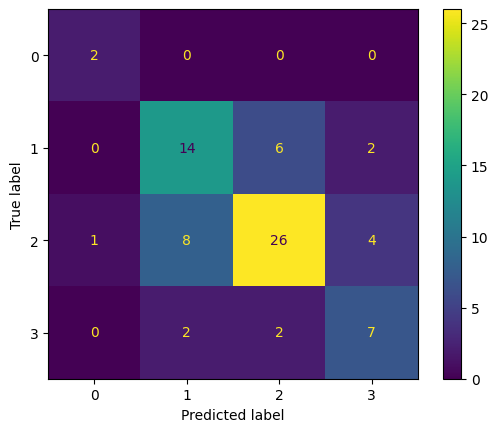

In [94]:
print(balanced_accuracy_score(target_test, pred))
print(classification_report(target_test, pred, labels=best_pipeline.classes_))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(target_test, pred, labels=best_pipeline.classes_)).plot()
plt.show()

Модель показала ожидаемое качество, также видно, что модель пытается предсказывать все возможные классы и даже если не угадывает, то предсказывает соседний класс, что может быть допустимым для заказчика.

Сохраним получившийся обученный пайплайн.

In [95]:
import joblib
joblib.dump(best_pipeline, 'best_pipeline.ppl')

['best_pipeline.ppl']

# Выводы

В ходе проделанной работы были изучены разбитые на уровни сложности английского фильмы. Для фильмов были собраны недостающие субтитры, произведена подготовка субтитров для возможности их использования в моделях машинного обучения. В ходе анализа предоставленных фильмов был обнаружен достаточно сильный дисбаланс в уровнях сложности, было предтавлено мало фильмов с категорией A2, также были представлены промежуточные категории. В связи с недостаточностью данных было принято решение избавить от промежуточных категорий, для борьбы с дисбалансов была применена генерация синтетических данных на основании имеющихся, однако это не заменит настоящих данных.
В итоге удалось получить модель с качеством balanced accuracy 0.764 со стандартным отклонением 0.042. Модель была проверена на тестовой выборке, результаты уложились в доверительный интервал.
В качестве дальнейшего улучшения качества рекомендуется предоставить большее число размеченных фильмов.
Для текущей модели был разработан веб-сервис, на катором по загруженным файлам с субтитрами можно получить уровень фильма, сервис расположен [по адресу](https://movie-english-level.streamlit.app/).